In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Extracting the Main CSV file and moving it into a Data Frame

In [2]:
file_path = '/content/drive/My Drive/Superstore_data/Superstore.csv'
df = pd.read_csv(file_path, encoding='latin-1')
print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

#Extracting the Regional Temperature CSV file and moving it into a Data Frame

In [3]:
file_path_1 = '/content/drive/My Drive/Superstore_data/Weather_Data.csv'
df1 = pd.read_csv(file_path_1, encoding='latin-1')
print(df1.head())

      Month  Year Region  Mean Temp (F)  Mean Max Temp (F)  Mean Min Temp (F)
0   January  2014  South           25.9               35.4               16.4
1  February  2014  South           29.7               39.1               20.4
2     March  2014  South           39.7               51.1               28.4
3     April  2014  South           57.8               68.6               47.0
4       May  2014  South           68.1               77.8               58.4


Break down of Order Date

In [4]:
# Convert the date column to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

# Extract the month and year
df['Month'] = df['Order Date'].dt.month_name()  # Full month name
df['Year'] = df['Order Date'].dt.year           # Year
df['Week of Year'] = df['Order Date'].dt.isocalendar().week
print(df.head())

   Row ID        Order ID Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

          Category  Sub-Category  \
0        Furniture     Bookcases   
1        Furniture        

Extracting Unique years from the DF

In [5]:
unique_years_sorted = sorted(df['Year'].unique())
print(unique_years_sorted)

[2014, 2015, 2016, 2017]


#Beautiful Soup to Extract Holidays for the Unique years

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

df_list = []

for year in unique_years_sorted:
  # URL of the website
  url = "https://www.federalholidays.net/usa/federal-holidays-2019.html"

  # Make an HTTP GET request to fetch the HTML content
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
    # Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Locate the parent div that contains the holiday data
    holiday_container = soup.find('div', {'class': 'container'})  # Adjust this selector based on structure
    holiday_rows = holiday_container.find_all('tr')  # Looks for row-like structures (if applicable)

    # Extract the holiday information
    holiday_data = []
    for row in holiday_rows[1:]:  # Skip the header row if applicable
        cells = row.find_all('td')
        holiday_data.append({
            "Date": cells[0].text.strip(),
            "Day of Week": cells[1].text.strip(),
            "Holiday Name": cells[2].text.strip()
        })

    # Convert to a Pandas DataFrame
    df1 = pd.DataFrame(holiday_data)

    # Add the year column dynamically
    df1['Year'] = year

    df_list.append(df1)

# Combine all the DataFrames into one
holidays_df = pd.concat(df_list, ignore_index=True)

# Convert to datetime format using the year column
holidays_df['Date'] = holidays_df.apply(
    lambda row: pd.to_datetime(f"{row['Date']} {row['Year']}", format="%B %d %Y").strftime("%m/%d/%y"),
    axis=1
)

# Drop the unnecessary 'Year' column
holidays_df = holidays_df.drop(columns=['Year','Day of Week'])

# Show the updated DataFrame
#print(holidays_df)

holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], errors='coerce')

holidays_df['Week of Year'] = holidays_df['Date'].dt.isocalendar().week
holidays_df['Month'] = holidays_df['Date'].dt.month_name()  # Full month name
holidays_df['Year'] = holidays_df['Date'].dt.year

# Check the result
print(holidays_df.head())

        Date                                Holiday Name  Week of Year  \
0 2014-01-01                              New Year’s Day             1   
1 2014-01-21         Birthday of Martin Luther King, Jr.             4   
2 2014-02-18  Washington’s Birthday (aka Presidents Day)             8   
3 2014-05-27                                Memorial Day            22   
4 2014-07-04                            Independence Day            27   

      Month  Year  
0   January  2014  
1   January  2014  
2  February  2014  
3       May  2014  
4      July  2014  


<ipython-input-6-097db758c60e>:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], errors='coerce')


Checker Column to Find Purchases made during Holiday weeks

In [7]:
# Step 1: Check if the transaction's Year, Month, and Week of Year match any in the holiday dataframe
def is_holiday_week(row):
    # Check if there's a match in the holiday dataframe for the transaction's Year, Month, and Week
    match = holidays_df[(holidays_df['Year'] == row['Year']) &
                       (holidays_df['Month'] == row['Month']) &
                       (holidays_df['Week of Year'] == row['Week of Year'])]
    # Return 1 if there's a match, else 0
    return 1 if not match.empty else 0

# Step 2: Apply the function to each row of the transaction dataframe
df['Holiday Week'] = df.apply(is_holiday_week, axis=1)

# Show the updated dataframe with the 'Holiday Week' column
print(df.head())

   Row ID        Order ID Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Sub-Category                                       Product Name     Sales  \
0    Bookcases     

Extracting Unique Regions from the Main DF


In [8]:
unique_regions_sorted = sorted(df['Region'].unique())
print(unique_regions_sorted)

['Central', 'East', 'South', 'West']


#Left Join to Merge both the Datasets

In [8]:
final_df = pd.merge(df, df1, on=['Month', 'Year', 'Region'], how='left')

Storing the final dataset

In [9]:
from google.colab import files
final_df.to_csv('/content/drive/My Drive/Superstore_data/Superstore_final.csv', index=False)
files.download('/content/drive/My Drive/Superstore_data/Superstore_final.csv')

In [10]:
file_path = '/content/drive/My Drive/Superstore_data/Superstore_final.csv'
df2 = pd.read_csv(file_path, encoding='latin-1')
df2.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Quantity,Discount,Profit,Month,Year,Week of Year,Mean Temp (F),Mean Max Temp (F),Mean Min Temp (F),Holiday Week
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,2,0.00,41.9136,November,2016,45,50.9,62.2,39.6,1
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,3,0.00,219.5820,November,2016,45,50.9,62.2,39.6,1
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,2,0.00,6.8714,June,2016,23,80.9,96.5,65.3,0
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,5,0.45,-383.0310,October,2015,41,59.5,70.7,48.3,0
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,2,0.20,2.5164,October,2015,41,59.5,70.7,48.3,0


Checking for Null Values

In [11]:
# Check for missing values
print(df2.isnull().sum())

Row ID               0
Order ID             0
Order Date           0
Ship Date            0
Ship Mode            0
Customer ID          0
Customer Name        0
Segment              0
Country              0
City                 0
State                0
Postal Code          0
Region               0
Product ID           0
Category             0
Sub-Category         0
Product Name         0
Sales                0
Quantity             0
Discount             0
Profit               0
Month                0
Year                 0
Week of Year         0
Mean Temp (F)        0
Mean Max Temp (F)    0
Mean Min Temp (F)    0
Holiday Week         0
dtype: int64


Normalizing Data

In [12]:
# Remove unwanted characters from location columns
df2['City'] = df2['City'].str.title().str.strip()
df2['State'] = df2['State'].str.upper().str.strip()

df2.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Quantity,Discount,Profit,Month,Year,Week of Year,Mean Temp (F),Mean Max Temp (F),Mean Min Temp (F),Holiday Week
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,2,0.00,41.9136,November,2016,45,50.9,62.2,39.6,1
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,3,0.00,219.5820,November,2016,45,50.9,62.2,39.6,1
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,2,0.00,6.8714,June,2016,23,80.9,96.5,65.3,0
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,5,0.45,-383.0310,October,2015,41,59.5,70.7,48.3,0
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,2,0.20,2.5164,October,2015,41,59.5,70.7,48.3,0


#EDA (Exploratory Data Analysis)

#Profitability by Category


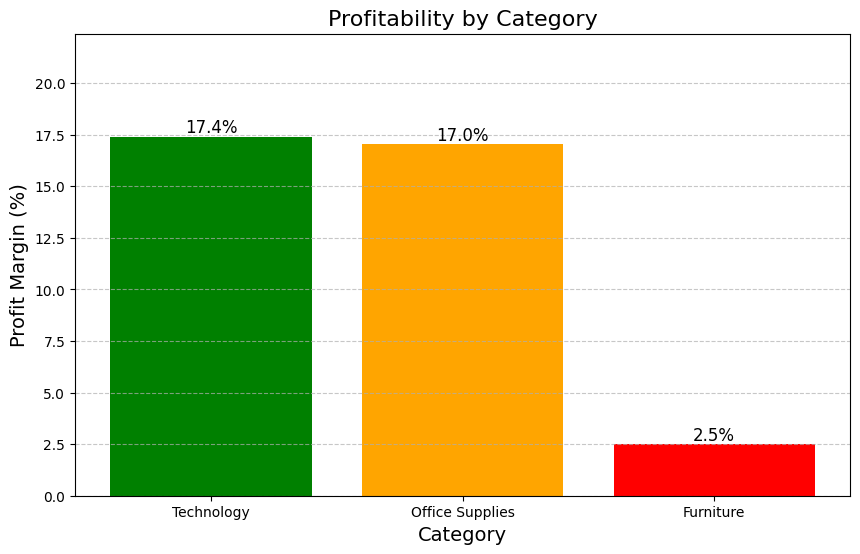

In [13]:


# Group by Category and calculate total Sales and Profit
category_profitability = df2.groupby("Category").agg({"Sales": "sum", "Profit": "sum"})

# Calculate Profit Margin (%)
category_profitability["Profit Margin (%)"] = (category_profitability["Profit"] / category_profitability["Sales"]) * 100

# Sort by Profit Margin
category_profitability = category_profitability.sort_values("Profit Margin (%)", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
colors = ["green", "orange", "red"]  # Custom colors for different categories

bars = plt.bar(category_profitability.index, category_profitability["Profit Margin (%)"], color=colors)

# Add labels
plt.xlabel("Category", fontsize=14)
plt.ylabel("Profit Margin (%)", fontsize=14)
plt.title("Profitability by Category", fontsize=16)
plt.ylim(0, category_profitability["Profit Margin (%)"].max() + 5)  # Adjust y-axis for better visibility
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}%", ha="center", va="bottom", fontsize=12)

plt.show()


#Sales vs Discount Trend Line

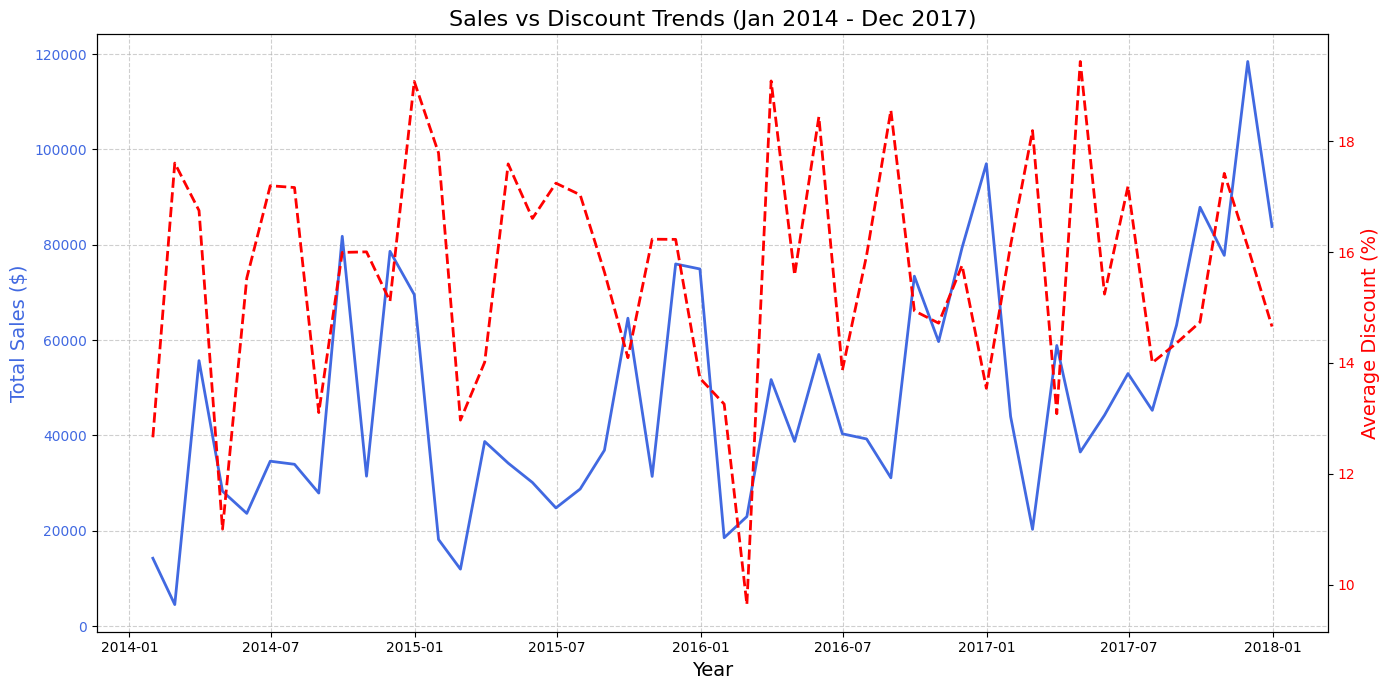

In [14]:


# Convert Order Date to datetime format
df2["Order_Date"] = pd.to_datetime(df2["Order Date"])

# Resample data to monthly frequency, summing Sales and averaging Discount
monthly_trends = df2.resample('ME', on='Order_Date').agg({"Sales": "sum", "Discount": "mean"})

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Sales (Primary Y-axis)
ax1.plot(monthly_trends.index, monthly_trends["Sales"], label="Sales ($)", color="royalblue", linewidth=2)
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Total Sales ($)", fontsize=14, color="royalblue")
ax1.tick_params(axis="y", labelcolor="royalblue")

# Create secondary axis for Discount
ax2 = ax1.twinx()
ax2.plot(monthly_trends.index, monthly_trends["Discount"] * 100, label="Discount (%)", color="red", linestyle="dashed", linewidth=2)
ax2.set_ylabel("Average Discount (%)", fontsize=14, color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Formatting
plt.title("Sales vs Discount Trends (Jan 2014 - Dec 2017)", fontsize=16)
ax1.grid(axis="both", linestyle="--", alpha=0.6)
fig.tight_layout()  # Adjust layout for better spacing

plt.show()


#Discount vs Profit Plot Chart


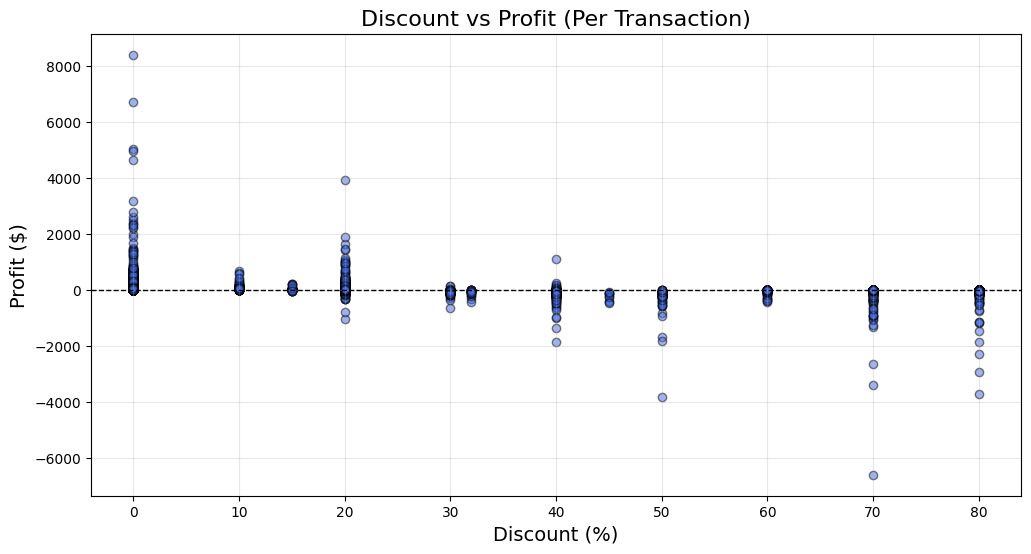

In [15]:
import matplotlib.pyplot as plt

# Scatter plot: Discount vs Profit
plt.figure(figsize=(12, 6))
plt.scatter(df2["Discount"] * 100, df2["Profit"], alpha=0.5, color="royalblue", edgecolors="black")

# Labels and Titles
plt.xlabel("Discount (%)", fontsize=14)
plt.ylabel("Profit ($)", fontsize=14)
plt.title("Discount vs Profit (Per Transaction)", fontsize=16)

# Grid and layout
plt.grid(alpha=0.3)
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)  # Zero profit reference line
plt.show()


#Sales by Region and Cities

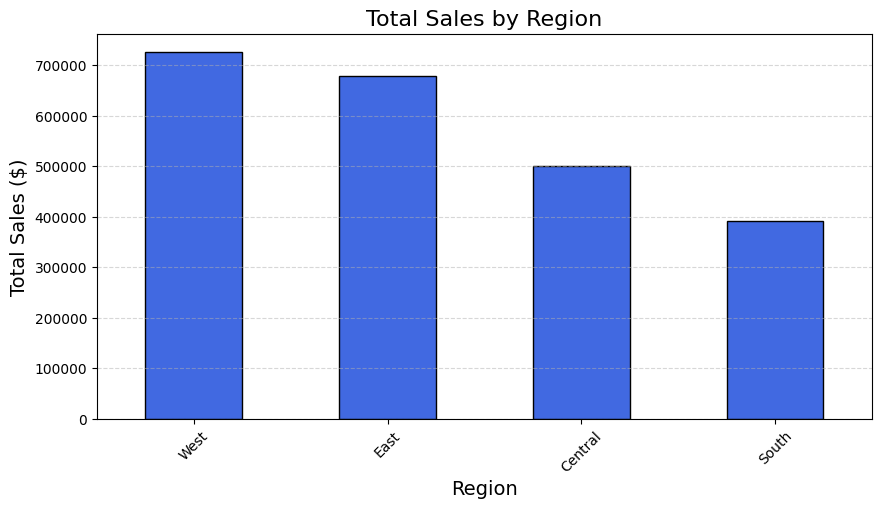

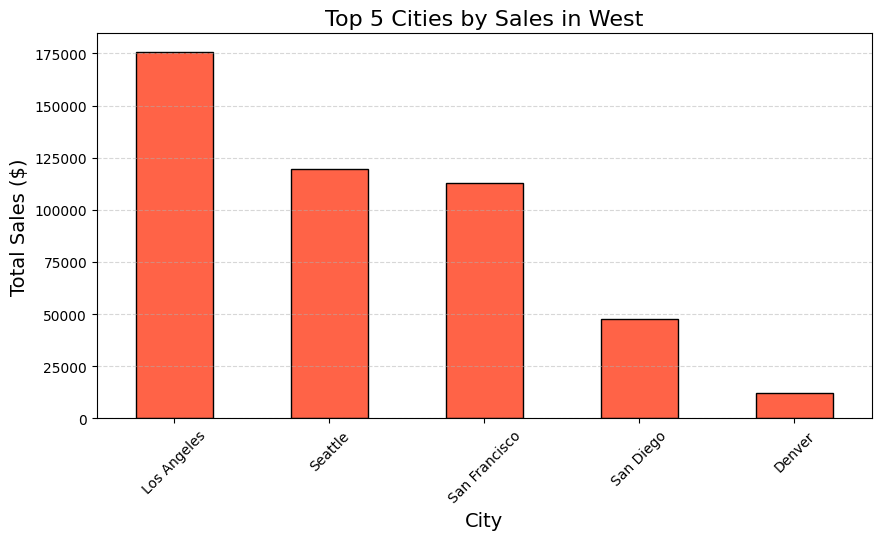

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Total Sales by Region
region_sales = df2.groupby("Region")["Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
region_sales.plot(kind="bar", color="royalblue", edgecolor="black")

plt.xlabel("Region", fontsize=14)
plt.ylabel("Total Sales ($)", fontsize=14)
plt.title("Total Sales by Region", fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

# Step 2: Find the Region with the Highest Sales
top_region = region_sales.idxmax()  # Get the region with max sales

# Filter data for only that region
top_region_data = df2[df2["Region"] == top_region]

# Aggregate total sales by city and get top 5
top_cities = top_region_data.groupby("City")["Sales"].sum().sort_values(ascending=False).head(5)

# Plot top 5 city sales within the highest sales region
plt.figure(figsize=(10, 5))
top_cities.plot(kind="bar", color="tomato", edgecolor="black")

plt.xlabel("City", fontsize=14)
plt.ylabel("Total Sales ($)", fontsize=14)
plt.title(f"Top 5 Cities by Sales in {top_region}", fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


#Customer Segment by Profit and Sales

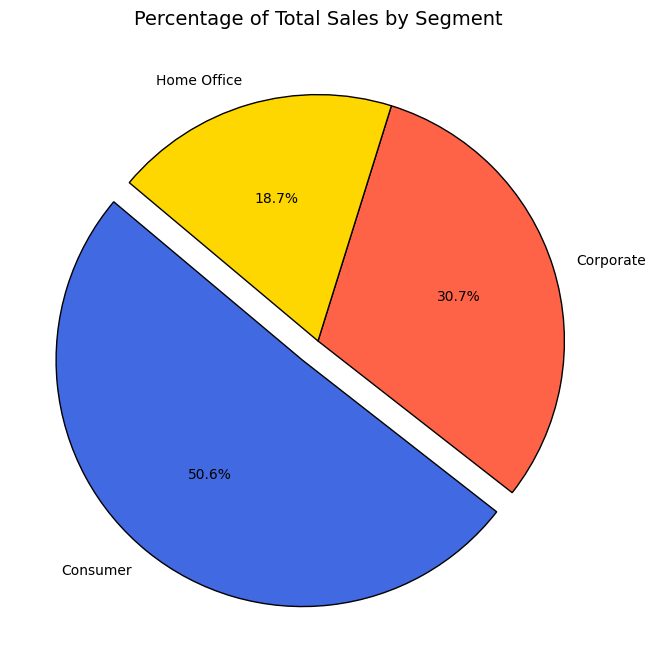

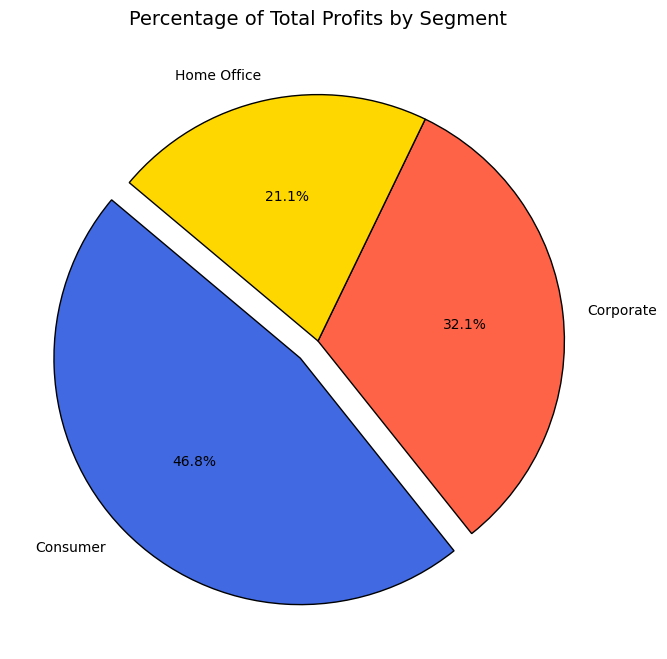

In [17]:
import matplotlib.pyplot as plt

# Step 1: Aggregate total sales by Segment
segment_sales = df2.groupby("Segment")["Sales"].sum()

# Step 2: Identify the highest sales segment
max_index = segment_sales.idxmax()  # Find segment with max sales

# Step 3: Create explode values (pop out the highest segment)
explode = [0.1 if segment == max_index else 0 for segment in segment_sales.index]

# Step 4: Plot the Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    segment_sales,
    labels=segment_sales.index,
    autopct='%1.1f%%',  # Show percentage values
    startangle=140,
    colors=["royalblue", "tomato", "gold"],  # Custom colors
    wedgeprops={'edgecolor': 'black'},
    explode=explode  # Pop out highest segment
)

plt.title("Percentage of Total Sales by Segment", fontsize=14)
plt.show()

# Step 1: Aggregate total profits by Segment
segment_profits = df2.groupby("Segment")["Profit"].sum()

# Step 2: Identify the highest profit segment
max_index = segment_profits.idxmax()  # Find segment with max profit

# Step 3: Create explode values (pop out the highest segment)
explode = [0.1 if segment == max_index else 0 for segment in segment_profits.index]

# Step 4: Plot the Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    segment_profits,
    labels=segment_profits.index,
    autopct='%1.1f%%',  # Show percentage values
    startangle=140,
    colors=["royalblue", "tomato", "gold"],  # Custom colors
    wedgeprops={'edgecolor': 'black'},
    explode=explode  # Pop out highest profit segment
)

plt.title("Percentage of Total Profits by Segment", fontsize=14)
plt.show()

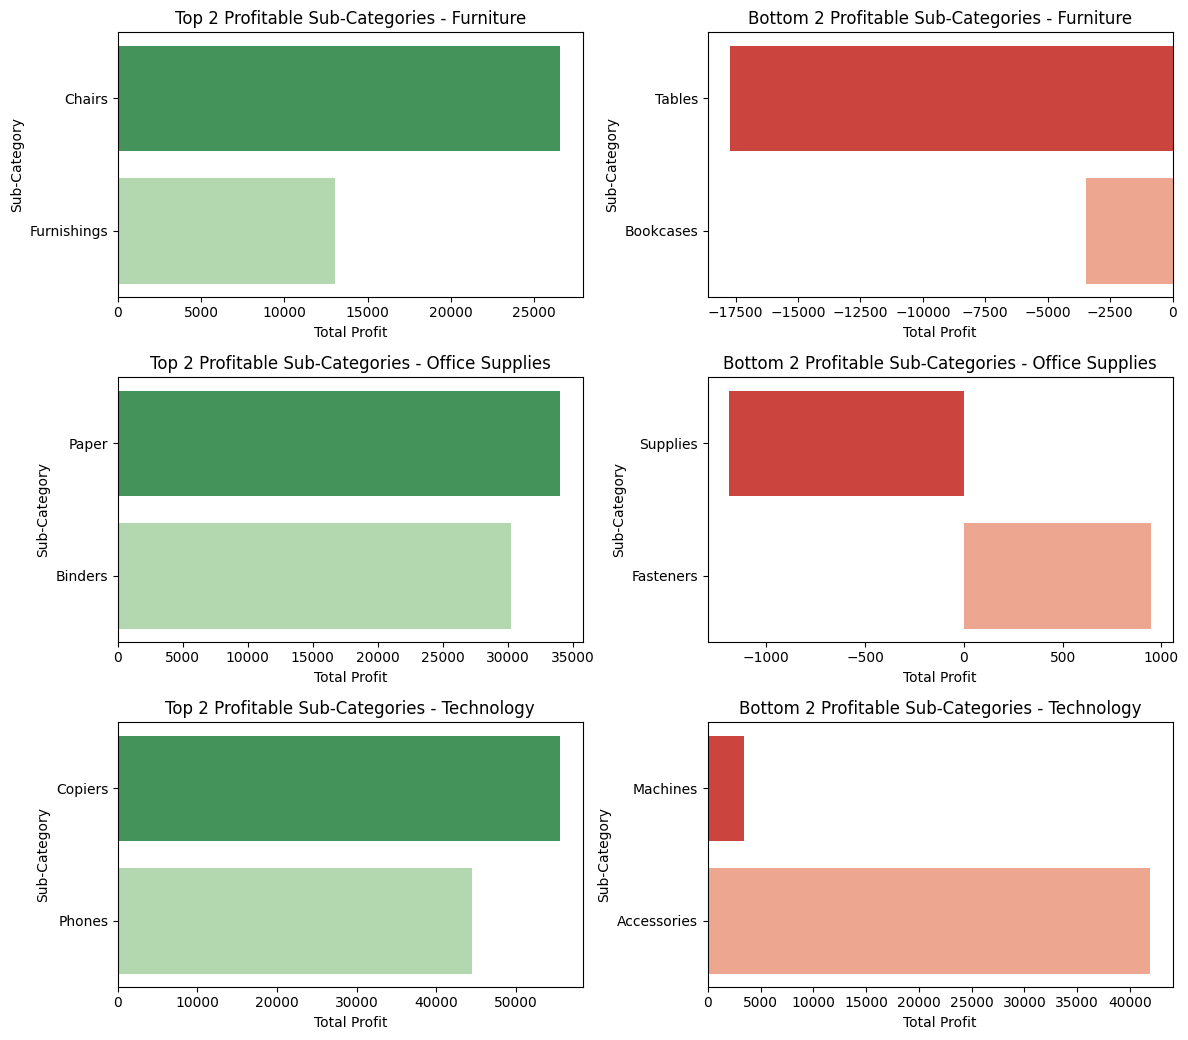

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Step 1: Aggregate total profit by Category and Sub-Category
category_profit = df2.groupby(["Category", "Sub-Category"])["Profit"].sum().reset_index()

# Step 2: Get unique categories
categories = category_profit["Category"].unique()

# Step 3: Set up subplots
fig, axes = plt.subplots(len(categories), 2, figsize=(12, 3.5 * len(categories)))

for i, category in enumerate(categories):
    # Filter data for the specific category
    cat_df = category_profit[category_profit["Category"] == category]

    # Top 2 most profitable sub-categories
    top_profit = cat_df.nlargest(2, "Profit")

    # Top 2 most loss-making sub-categories
    top_loss = cat_df.nsmallest(2, "Profit")

    # Plot profitable sub-categories
    sns.barplot(
        x="Profit", y="Sub-Category",
        data=top_profit, ax=axes[i, 0], palette="Greens_r"
    )
    axes[i, 0].set_title(f"Top 2 Profitable Sub-Categories - {category}")
    axes[i, 0].set_xlabel("Total Profit")

    # Plot loss-making sub-categories
    sns.barplot(
        x="Profit", y="Sub-Category",
        data=top_loss, ax=axes[i, 1], palette="Reds_r"
    )
    axes[i, 1].set_title(f"Bottom 2 Profitable Sub-Categories - {category}")
    axes[i, 1].set_xlabel("Total Profit")

# Adjust layout
plt.tight_layout()
plt.show()



#Advance Analytics


Correlation Mastrix between Sales, Profit, Discount, Quantit and Temperature

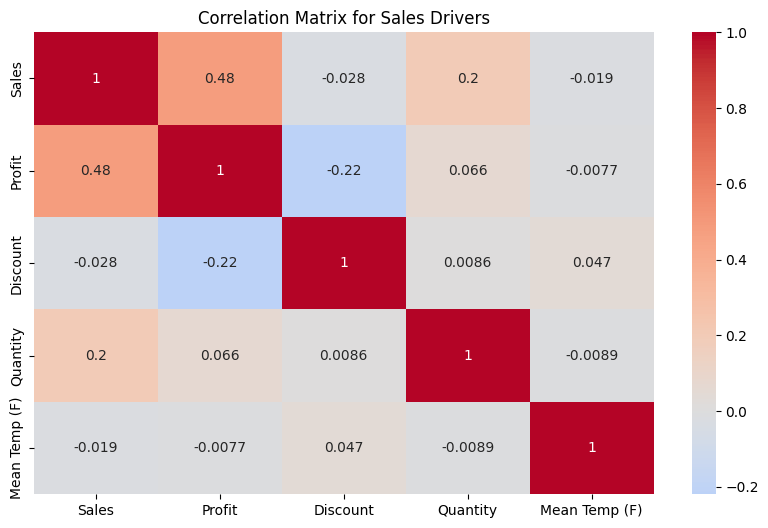

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df2[['Sales', 'Profit', 'Discount', 'Quantity', 'Mean Temp (F)']].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix for Sales Drivers")
plt.show()

Cluster Generation for Customer best customer segmentation

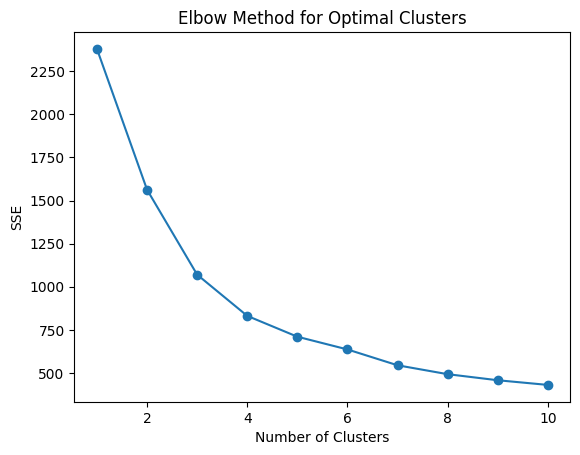

   Cluster     Recency  Frequency     Monetary
0        0   73.198529  17.628676  3659.052188
1        1   95.237430   8.882682  1594.209342
2        2  117.413793  20.689655  9756.423241
3        3  544.619048   7.800000  1574.658788


In [20]:
# Calculate RFM metrics
rfm = df2.groupby('Customer ID').agg({
    'Order Date': 'max',  # Most recent purchase
    'Order ID': 'count',  # Frequency
    'Sales': 'sum'        # Monetary value
}).rename(columns={'Order Date': 'Recency', 'Order ID': 'Frequency', 'Sales': 'Monetary'})

# Recency: Days since last purchase
rfm['Recency'] = (pd.to_datetime('January 1 2018') - pd.to_datetime(rfm['Recency'])).dt.days

# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-Means Clustering
from sklearn.cluster import KMeans

# Find optimal clusters (Elbow Method)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Fit K-Means (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()
print(cluster_summary)